Author: Pascal, pascal@bayesimpact.org

Date: 2019-12-18

# ROME update from v341 to v342

In December 2019 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v341. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '341'
NEW_VERSION = '342'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


Cool, no new nor deleted files.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
def read_csv(filename):
    try:
        return pd.read_csv(filename)
    except pd.errors.ParserError:
        display(f'While parsing: {filename}')
        raise

rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

Columns of unix_referentiel_appellation_v342_utf8.csv have changed.


OK, let's check what's new in there:

In [5]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')
print(f'New columns: {set(jobs.old.columns) - set(jobs.new.columns)}')
print(f'Old columns: {set(jobs.new.columns) - set(jobs.old.columns)}')

New columns: {'lib_type_section_appellation'}
Old columns: {'libelle_type_section_appellation'}


Ouch, it seems they have decided to rename one column, however the opposite change was done when going to v341, so they're just reverting back. Lucky us we never used it.

Now let's see for each file if there are more or less rows.

In [6]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

756/32179 values added in unix_coherence_item_v342_utf8.csv
9/11727 values added in unix_cr_gd_dp_appellations_v342_utf8.csv
62/13631 values added in unix_item_v342_utf8.csv
765/43782 values added in unix_liens_rome_referentiels_v342_utf8.csv
4/8975 values added in unix_referentiel_activite_riasec_v342_utf8.csv
4/8975 values added in unix_referentiel_activite_v342_utf8.csv
9/11071 values added in unix_referentiel_appellation_v342_utf8.csv
43/4923 values added in unix_referentiel_competence_v342_utf8.csv
2/766 values added in unix_referentiel_env_travail_v342_utf8.csv
2/5045 values added in unix_texte_v342_utf8.csv
10/20 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, and liens_rome_referentiels, so let's see more precisely.

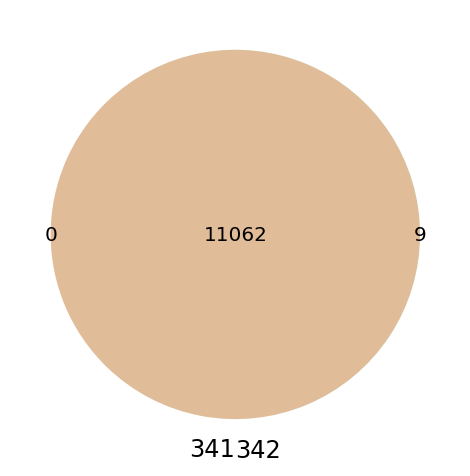

In [7]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 9 new jobs added. Let's take a look (only showing interesting fields):

In [8]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
11062,200020,Assistant / Assistante de régulation médicale,D1408
11063,200021,Chargé / Chargée d'affaires réglementaires en industrie de santé,H1502
11064,200022,Chargé / Chargée de matériovigilance,H1502
11065,200023,Infirmier / Infirmière en Pratique Avancée,J1506
11066,200024,Graphothérapeute,K1104
11067,200025,Directeur / Directrice de l'environnement de travail,M1205
11068,200026,Assistant/ Assistante de l'environnement de travail,M1605
11069,200027,Scrum Master,M1805
11070,200028,Product Owner,M1806


Those are indeed new jobs. Some are related to Agile sneaking in.

OK, let's check at the changes in items:

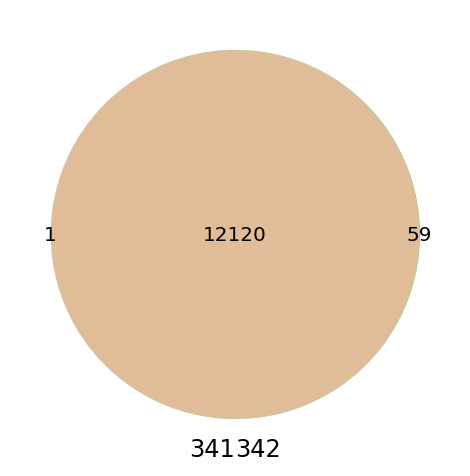

In [9]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): 59 new ones have been created. Let's have a look at them.

In [10]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
5151,113277,Méthode AGILE,1,7,NaN,NaN,NaN
5961,115851,Réglementation thermique,1,7,NaN,NaN,NaN
5967,115869,Système KANBAN,1,10,NaN,NaN,NaN
7040,118748,Méthodologie Scrum,1,10,NaN,NaN,NaN
7175,119013,Réaliser la gestion administrative et financière d'un chantier,2,6,NaN,NaN,NaN


The new ones seem legit to me and related to the new jobs.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [11]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added      47
removed    28
Name: _diff, dtype: int64

So in addition to the added items, there are few fixes. Let's have a look at them:

In [12]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
24509,K2110,120406,left_only,removed,Formation en conduite de véhicules,Engins de chantier (CACES R 372)
24510,K2110,120407,left_only,removed,Formation en conduite de véhicules,Chariots automoteurs de manutention à conducteur porté (CACES R 389)
24511,K2110,120408,left_only,removed,Formation en conduite de véhicules,Grues auxiliaires de chargement de véhicules (CACES R 390)
24518,K2110,121308,left_only,removed,Formation en conduite de véhicules,Ponts roulants (CACES R 318)
24519,K2110,121310,left_only,removed,Formation en conduite de véhicules,Grues mobiles (CACES R 383)


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
31422,D1408,123009,right_only,added,Téléconseil et télévente,Nouvelles Technologies de l'information et de la Communication (NTIC)
31423,D1408,102694,right_only,added,Téléconseil et télévente,Renseigner les supports de suivi d'intervention et transmettre les informations au service concerné
31424,D1408,103885,right_only,added,Téléconseil et télévente,Gestes d'urgence et de secours
31425,D1408,107361,right_only,added,Téléconseil et télévente,Terminologie médicale
31426,F1201,117170,right_only,added,Conduite de travaux du BTP et de travaux paysagers,"Coordonner les prestataires, fournisseurs, intervenants"


The added items are OK. Removing the CACES (physical security certifications) from the first one seems dodgy, let's check what this job group is about:

In [13]:
jobs.new[jobs.new.code_rome == 'K2110'].head()

,code_ogr,libelle_appellation_long,libelle_appellation_court,code_rome,code_type_section_appellation,libelle_type_section_appellation,statut
74,10275,Adjoint / Adjointe au responsable d'auto-école,Adjoint / Adjointe au responsable d'auto-école,K2110,1,PRINCIPALE,1
4583,14851,Enseignant / Enseignante de la conduite et de la sécurité routière,Enseignant(e) de la conduite et de la sécurité routière,K2110,1,PRINCIPALE,1
4856,15126,Formateur / Formatrice conduite d'engins de travaux publics,Formateur / Formatrice conduite d'engins de travaux publics,K2110,1,PRINCIPALE,1
4857,15127,Formateur / Formatrice conduite d'engins motorisés et de levage,Formateur(trice) conduite d'engins motorisés et de levage,K2110,1,PRINCIPALE,1
4862,15133,Formateur / Formatrice de conducteurs routiers,Formateur / Formatrice de conducteurs routiers,K2110,1,PRINCIPALE,1


OK, so it's actually the job for the trainers that might not require the CACES for themselves.

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v342, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf).

Technically they were some format changes (that were discovered while preparing this notebook):
* The CSV files were zipped under a `csv` folder, are now directly at the root of the zip (reverting a change introduced in v341)
* The double quotes are now escaped.

The transition should be transparent with a very small advantage over the old version.